# Emotion Detection in Persian Texts

**Student Name:** <span style="color:cyan">Ardalan Siavashpour</span>

**Student ID:** <span style="color:cyan">99109896</span>

## 1. Project Overview and Goals

In this assignment, you will build a machine learning pipeline to detect emotions in a single-label collection of Persian texts. The dataset is categorized into five emotional classes: **HAPPY, SAD, ANGRY, FEAR, and OTHER**.

### Your Tasks:

*   **Data Cleaning & Feature Engineering:** Preprocess the Persian text data.
*   **Model Selection:** Choose a suitable classical machine learning model.
*   **Pipeline Construction:** Use the provided `EmotionClassifierPipeline` class to encapsulate your workflow.
*   **Model Evaluation:** Use K-Fold/Stratified K-Fold cross-validation to evaluate your model's performance and interpret the results.
*   **Prediction:** Train your final pipeline on the entire training dataset and generate predictions for the unlabeled test set.
*   **Submission:** Save your test predictions to a CSV file named `submission.csv`.

**Grading:** Achieving an accuracy level above **65%** on the hidden test set will result in full marks.

## 2. Setup and Data Loading

First, let's import the necessary libraries and load our data.

In [156]:
!pip install pandas numpy scikit-learn openpyxl


In [157]:
# Basic libraries for data manipulation
import pandas as pd
import numpy as np
import re

# Scikit-learn modules for machine learning
from sklearn.model_selection import KFold

# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [158]:
# --- Load the Datasets ---
# Make sure the files 'HW1P1_train.xlsx' and 'HW1P1_test.csv' are in the same directory.
df_train = pd.read_excel('Twitter_train.xlsx')
df_test = pd.read_csv('Twitter_test.csv')

print("--- Training Data Head ---")
display(df_train.head())

print("\n--- Test Data Head ---")
display(df_test.head())

--- Training Data Head ---


,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
0,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER
1,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD
2,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY
3,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY
4,اگه تو بغلت بودم حالم خیلی بهتر میشد,SAD



--- Test Data Head ---


,صعب روزی، بوالعجب کاری، پریشان عالمی
0,بسیار نرم و لطیف بوده و کیفیت بالایی داره.
1,اصلا رنگش با چیزی که تو عکس بود خیلی فرق داشت
2,خیلی زیبا و ب اندازه و با دقت طراحی شده
3,سبزی پلو با ماهی مال عید نوروزه، امشب سوشی میخ...
4,لج بازیو بذار کنار یه فرصت دیگه بهت میدم


## 3. Exploratory Data Analysis (EDA) and Preprocessing

### 3.1. Analyze Class Distribution

**TODO:** Analyze and visualize the distribution of emotions in the training set. Is the dataset balanced?

--- Class Distribution ---

Absolute counts:
emotion
HAPPY    1462
OTHER    1263
ANGRY    1012
SAD       844
FEAR      342
Name: count, dtype: int64

Percentages:
emotion
HAPPY    29.70
OTHER    25.66
ANGRY    20.56
SAD      17.14
FEAR      6.95
Name: proportion, dtype: float64


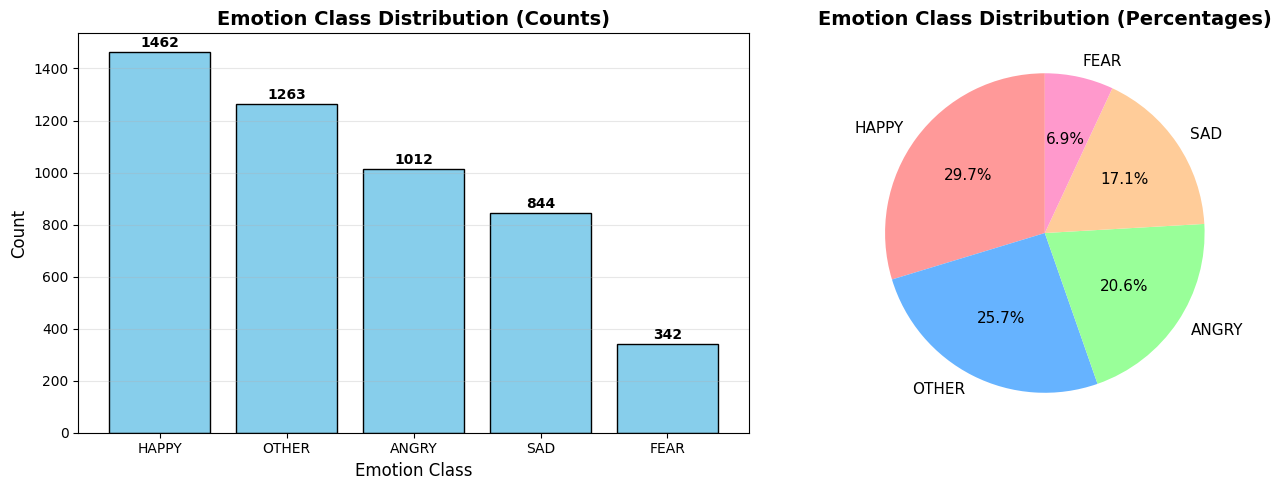


--- Balance Analysis ---
Maximum class count: 1462
Minimum class count: 342
Imbalance ratio: 4.27
✗ Dataset is HIGHLY IMBALANCED - Consider using Stratified K-Fold or class weights


In [159]:
## 3.1. Analyze Class Distribution

# First, let's fix the column names (they seem to have the data as column names)
# The first column is the text, the second is the emotion
df_train.columns = ['text', 'emotion']
df_test.columns = ['text']

# Analyze class distribution
class_counts = df_train['emotion'].value_counts()
class_percentages = df_train['emotion'].value_counts(normalize=True) * 100

print("--- Class Distribution ---")
print("\nAbsolute counts:")
print(class_counts)
print("\nPercentages:")
print(class_percentages.round(2))

# Visualize the distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot - counts
axes[0].bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Emotion Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Emotion Class Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, (label, count) in enumerate(zip(class_counts.index, class_counts.values)):
    axes[0].text(i, count + 20, str(count), ha='center', fontsize=10, fontweight='bold')

# Pie chart - percentages
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
axes[1].pie(class_percentages.values, labels=class_percentages.index, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 11})
axes[1].set_title('Emotion Class Distribution (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check if dataset is balanced
print("\n--- Balance Analysis ---")
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"Maximum class count: {max_count}")
print(f"Minimum class count: {min_count}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio <= 1.5:
    print("✓ Dataset is BALANCED")
elif imbalance_ratio <= 3:
    print("⚠ Dataset is MODERATELY IMBALANCED")
else:
    print("✗ Dataset is HIGHLY IMBALANCED - Consider using Stratified K-Fold or class weights")

### 3.2. Text Cleaning and Preprocessing

**TODO:** Implement a function to clean the Persian text. Consider steps like normalization, removing punctuation and numbers, and handling stop words. Apply this function to create a new `cleaned_text` column in both `df_train` and `df_test`.

In [160]:
# A small but useful Persian stopword list (you can extend it if needed)
# PERSIAN_STOPWORDS = {
#     'و', 'در', 'به', 'از', 'که', 'این', 'آن', 'برای', 'با', 'است', 'را',
#     'ای', 'یک', 'ها', 'می', 'اما', 'یا', 'اگر', 'تا', 'هم', 'هر', 'هیچ',
#     'همه', 'نیز', 'بین', 'بود', 'هست', 'شد', 'شده', 'باشند', 'باشیم',
#     'کند', 'کنند', 'کرد', 'کردن', 'خواهند', 'خواهد', 'خواهیم',
#     'تواند', 'توانند', 'باید', 'نباید', 'دیگر', 'چرا', 'چگونه', 'چطور',
#     'کجا', 'کدام', 'زیرا', 'چون', 'مثل', 'مانند', 'همین', 'همان',
#     'قبل', 'بعد', 'اما', 'بلکه', 'تا', 'نه', 'یا', 'حتی', 'ولی',
#     'اگرچه', 'یعنی', 'چند', 'بر', 'روی', 'توسط', 'بدون'
# }

In [161]:
import re


with open("stopwords.txt", encoding="utf-8") as f:
    PERSIAN_STOPWORDS = set(w.strip() for w in f if w.strip())

EMOTION_PUNCT = "!?؟:;…()«»،؛"


# Compile diacritics (tashdid, fatha, kasra, etc.) pattern once
PERSIAN_DIACRITICS_RE = re.compile(
    r'[\u0610-\u061A\u064B-\u065F\u06D6-\u06DC\u06DF-\u06E8\u06EA-\u06ED]+'
)

def _normalize_persian(text: str) -> str:
    """
    Normalize common Persian/Arabic characters and remove diacritics.
    """
    # Map Arabic forms to standard Persian forms
    char_map = {
        'ي': 'ی',
        'ى': 'ی',
        'ئ': 'ی',
        'ك': 'ک',
        'ؤ': 'و',
        'أ': 'ا',
        'إ': 'ا',
        'ٱ': 'ا',
        'ة': 'ه',
        'ۀ': 'ه',
        'ﻻ': 'لا',
    }
    # Translate using unicode ordinals
    translation_table = str.maketrans(char_map)
    text = text.translate(translation_table)

    # Remove diacritics (tashkeel)
    text = PERSIAN_DIACRITICS_RE.sub('', text)

    # Replace zero-width non-joiner with a normal space
    text = text.replace('\u200c', ' ')

    return text

def clean_persian_text(text):
    """
    Optimized cleaning for character n-gram models.
    """
    
    # 1. Handle non-string / NaN
    if not isinstance(text, str):
        return ""
    text = str(text)

    # 2. Normalize Persian script
    text = _normalize_persian(text)

    # 3. Remove URLs, emails
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)

    # 3b. Remove @mentions but KEEP hashtags as words
    text = re.sub(r'@\S+', ' ', text)
    text = re.sub(r'#(\S+)', r' \1 ', text)

    # 4. Remove digits (Persian + Arabic + Latin)
    text = re.sub(r'[0-9\u06F0-\u06F9\u0660-\u0669]+', ' ', text)

    # 5. Keep only Persian letters, spaces, and selected punctuation
    text = re.sub(fr'[^\u0600-\u06FF\s{re.escape(EMOTION_PUNCT)}]', ' ', text)

    # 5b. Put spaces around punctuation so they become separate tokens
    text = re.sub(f"([{re.escape(EMOTION_PUNCT)}])", r" \1 ", text)

    # 6. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()



    return text  # Return without stopword removal



df_train['cleaned_text'] = df_train['text'].apply(clean_persian_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_persian_text)

print("Text cleaning complete. Example:")
display(df_train[['text', 'cleaned_text']].head())


Text cleaning complete. Example:


,text,cleaned_text
0,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...
1,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...
2,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,خوبه تمام قسمت های گوشی رو محافظت می کنه
3,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,این خاک مال مردمان است نه حاکمان ایران مهسا امینی
4,اگه تو بغلت بودم حالم خیلی بهتر میشد,اگه تو بغلت بودم حالم خیلی بهتر میشد


## 4. Model Evaluation with Cross-Validation

**TODO:** Use (Stratified) K-Fold to evaluate different models and vectorizers. Your goal is to find the best combination.

In [162]:
## 4.y. Hyperparameter tuning for LinearSVC with character n-grams (using char_text)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Features and labels
X = df_train['cleaned_text']
y = df_train['emotion']

svc_char_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        sublinear_tf=True,
        min_df=1      # allow rare n-grams, we will test 1/2/3 below
    )),
    ("clf", LinearSVC())
])

param_grid = {
    "tfidf__ngram_range": [(2, 5), (3, 5), (3, 6), (2, 6)],
    "tfidf__min_df": [1, 2, 3],
    "clf__C": [0.5, 1.0, 2.0, 5.0, 10.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

grid = GridSearchCV(
    svc_char_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

print("Starting GridSearchCV on char_text...")
grid.fit(X, y)

print("\nBest parameters:", grid.best_params_)
print("Best CV accuracy: {:.4f}".format(grid.best_score_))

best_model = grid.best_estimator_

Starting GridSearchCV on char_text...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(2, 5); total time=   2.5s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 5); total time=   2.4s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(2, 5); total time=   2.6s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 5); total time=   2.3s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(2, 5); total time=   2.5s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 5); total time=   2.5s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(2, 5); total time=   2.5s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(2, 5); total time=   2.6s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 5); total time=   1.9s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3, 5); total time=   1.9s
[CV] END clf__C=0.5, tfidf__min_df=1, tfidf__ngram_range=(3,

## 5. Building the Machine Learning Pipeline

Here is a custom pipeline class provided for you. Your task is put your chosen components inside this class

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

class EmotionClassifierPipeline:
    """
    A custom pipeline class to handle text vectorization and classification.
    This class is provided for you to use.
    """
    def __init__(self, vectorizer, classifier):
        """
        Initializes the pipeline with chosen components.
        """
        self.vectorizer = vectorizer
        self.classifier = classifier

    def fit(self, X, y):
        """
        Trains the pipeline on the provided training data.
        """
        X_transformed = self.vectorizer.fit_transform(X)
        self.classifier.fit(X_transformed, y)
        return self

    def predict(self, X):
        """
        Predicts labels for new, unseen data.
        """
        X_transformed = self.vectorizer.transform(X)
        predictions = self.classifier.predict(X_transformed)
        return predictions





In [164]:
print(best_model)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', ngram_range=(3, 5),
                                 sublinear_tf=True)),
                ('clf', LinearSVC(C=0.5))])


## 6. Final Model Training and Prediction

Now, you will train your best-performing pipeline on the **entire training dataset** and generate predictions for the test set.

In [165]:
from sklearn.base import clone

# --- Reload the data to ensure we are working with the original sets ---
print("Reloading data for final training and prediction...")
df_train = pd.read_excel('Twitter_train.xlsx')
df_test = pd.read_csv('Twitter_test.csv')
df_train.columns = ['text', 'emotion']
df_test.columns = ['text']

# print(df_train.head())        

# --- Apply the SAME cleaning process ---
df_train['cleaned_text'] = df_train['text'].apply(clean_persian_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_persian_text)

print(f"Training samples: {len(df_train)}")
print(f"Test samples: {len(df_test)}")

# --- Get the best vectorizer & classifier automatically from best_model ---
# best_model = grid.best_estimator_  # already created above

best_vectorizer = best_model.named_steps["tfidf"]
best_classifier = best_model.named_steps["clf"]

# Clone them so we get fresh, unfitted copies with the same hyperparameters
final_vectorizer = clone(best_vectorizer)
final_classifier = clone(best_classifier)

print("\nBest hyperparameters used for final model:")
print("ngram_range:", final_vectorizer.ngram_range)
print("min_df:", final_vectorizer.min_df)
print("C:", final_classifier.C)

# --- Instantiate and Fit the Final Pipeline ---
print("\nTraining the final pipeline on all training data...")

final_pipeline = EmotionClassifierPipeline(
    vectorizer=final_vectorizer,
    classifier=final_classifier
)

# Fit the pipeline on the full, cleaned training data
final_pipeline.fit(df_train['cleaned_text'], df_train['emotion'])

print("✅ Final pipeline training complete.")

# --- Generate Predictions on the Test Set ---
print("\nGenerating predictions for the test set...")

# Predict using the cleaned test data
test_predictions = final_pipeline.predict(df_test['cleaned_text'])

# Add predictions to the test DataFrame
df_test['predicted_emotion'] = test_predictions

print("\n--- Test Data with Predictions (Top 5) ---")
display(df_test.head())


Reloading data for final training and prediction...
Training samples: 4923
Test samples: 547

Best hyperparameters used for final model:
ngram_range: (3, 5)
min_df: 1
C: 0.5

Training the final pipeline on all training data...
✅ Final pipeline training complete.

Generating predictions for the test set...

--- Test Data with Predictions (Top 5) ---


,text,cleaned_text,predicted_emotion
0,بسیار نرم و لطیف بوده و کیفیت بالایی داره.,بسیار نرم و لطیف بوده و کیفیت بالایی داره,HAPPY
1,اصلا رنگش با چیزی که تو عکس بود خیلی فرق داشت,اصلا رنگش با چیزی که تو عکس بود خیلی فرق داشت,ANGRY
2,خیلی زیبا و ب اندازه و با دقت طراحی شده,خیلی زیبا و ب اندازه و با دقت طراحی شده,HAPPY
3,سبزی پلو با ماهی مال عید نوروزه، امشب سوشی میخ...,سبزی پلو با ماهی مال عید نوروزه ، امشب سوشی می...,HAPPY
4,لج بازیو بذار کنار یه فرصت دیگه بهت میدم,لج بازیو بذار کنار یه فرصت دیگه بهت میدم,ANGRY


In [166]:
# --- Create the submission DataFrame ---
submission_df = pd.DataFrame({
    'text': df_test['text'],
    'emotion': df_test['predicted_emotion']
})

# --- Save to CSV ---
output_filename = 'submission.csv'
submission_df.to_csv(output_filename, index=False)

print(f"\n✅ Successfully saved predictions to '{output_filename}'.")
print(f"Total predictions: {len(submission_df)}")
display(submission_df.head(20))



✅ Successfully saved predictions to 'submission.csv'.
Total predictions: 547


,text,emotion
0,بسیار نرم و لطیف بوده و کیفیت بالایی داره.,HAPPY
1,اصلا رنگش با چیزی که تو عکس بود خیلی فرق داشت,ANGRY
2,خیلی زیبا و ب اندازه و با دقت طراحی شده,HAPPY
3,سبزی پلو با ماهی مال عید نوروزه، امشب سوشی میخ...,HAPPY
4,لج بازیو بذار کنار یه فرصت دیگه بهت میدم,ANGRY
5,بیا چندتا سیل جمعیت نشونت بدم تا دفعه بعدی به...,OTHER
6,دلم میخواد زیبا باشم و دوست داشته بشم:(,SAD
7,عباس علی‌زاده معروف به «بروس‌لی افغانستان» وار...,OTHER
8,امشب راحت میتوان به این موضوع پی برد مگه نه؟,OTHER
9,اگر #گاز دارید، خدا را #شُکر کنید و؛ با #صرفه_...,OTHER
